# Boundary Relation Tests

## Setup

### Imports

In [15]:
from math import sqrt, pi

# Shared Packages
import pandas as pd
import numpy as np

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [16]:
PRECISION = 2

In [17]:
%matplotlib inline

## Adjusting Boundary Slice Relations

For the beginning and ending slices of a structure the entire contour must
be treated as a boundary.  The structure does not have an interior on these
slices. In this case the “*Interior*” relations become “*Boundary*” relations.

The “*Interior*” bits of the DE-9IM relationship metric are combined with the 
“*Boundary*” bits using "OR" logic.  This will keep the “*Boundary*” bits as 
part of the boundary.


### Boundary Interpolation

- The last slice with a contour is not the actual boundary.  The boundary is
  half way between the last slice with a contour and the fist slice without a 
  contour.  
- The last slice is interpolated to create the boundary.
- The boundary slice index is half way between the two indexes (The mean).


#### Interpolation process
- Takes two polygons or one polygon an a "vanishing point" (The centroid of the polygon).
- Takes two SliceIndex values and calculates the mean as the new SliceIndex.
- For each coordinate point on the first polygon build a line from it to the 
  closest point on the second polygon.
- Return the half way point of this line as the new coordinate point.
- The new polygon is the set of all the new coordinate points.
_ To interpolate a polygon on a boundary slice, the centroid of the polygon is 
    used as the second point in the interpolation lines.
The Z value of the new point is the mean of the Z values of the two slices.


### Managing holes
The boundaries of holes must also be checked
- `adjust_boundary_relation` will need to be updated to include `shift_type`s for holes:
     - *hole_in_a* 
     - *hole_in_b*
     - *hole_in_both*
- The *holes* `shift_type` shifts the interior relation to a boundary relation only for the *contour* part.  The *exterior* and *hull* relation parts are not shifted.

- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.
  

When hole boundaries are tested, only the "contour" “*Boundary*” bits of the 'a' 
structure DE-9IM relationship


relation (DE27IM_Type): A triplet numeric DE-9IM relationship metric.
        

shift_type (str, optional): The polygon(s) that are boundaries:
- 'a' indicates that the first (primary) polygon is at a boundary.
- 'b' indicates that the second (secondary) polygon is at a boundary.
- 'both' (The default) indicates that both polygons are at a boundary.
- 'hole_in_a' indicates that the first polygon is at a boundary with a hole.
- 'hole_in_b' indicates that the second polygon is at a boundary with a hole.

###### Inverted Next_slice required for holes

### secondary boundary tests
- Applies to the Secondary ROI in the same way as the Primary ROI.
- The `boundary_match` and `match_neighbour_slices` functions will need to be adjusted to work for secondary boundaries as well.

|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Borders          |  `FF*FT****`  |   `T*T*F*FF*`   | `*********` |
|Borders result   |  `000011001`  |   `000011001`   | `000011001` |
|Interior Borders |  `FF*FT****`  |   `T***T****`   | `*********` |
|Result           |  `111001001`  |   `111001001`   | `001011101` |
                
**BORDERS:** The two structures share a common exterior boundary.

**BORDERS_INTERIOR:** The two structures share a common boundary and one is within the other.
    


|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Overlaps         |  `T*T***T**`  |   `*********`   | `*********` |
|Overlaps result  |  `110010001`  |   `110010001`   | `110010001` |

                
**OVERLAPS:** The two structures share a common region.
    

![alt text](Images/DE-9IM.png)

![alt text](../reference/RelationshipTreeDiagram.svg)

### Boundary checks are done by *region* not by *structure*

- For all structures the `StructureSlice.contour` MultiPolygon for each slice 
    is separated into individual polygons and holes (Regions).
- Unique labels are applied to each region on the first slice: 'a', 'b' ...
- Overlapping polygons on the next slice are given the same region labels.
- If a polygon in the current region is not matched to a polygon in the next 
    region, it is a tagged as a “*Boundary*” polygon.
- If a polygon in the next region is not matched with a polygon in the current 
    region, it is tagged as a “*Boundary*” polygon and assigned a new unique 
    region label.
- In the case where two regions that converge into one the distinct region 
    labels are kept. This is because a polygon can be in multiple regions.
  


# Question
- Slice 0.4 is a boundary for #5, and is a neighbour to the boundary for #1.
- Will it get the relation wrong if I test it as a boundary for both #1 and #5?
> Probably not, because regular relations are also tested  for slice 0.4.  
> For 0.4, #5 will be external to #1.


Matched boundary slices are those that are boundary slices of both structures. 

The boundary slices are selected based on the following conditions:
1. The 
slice is at a boundary of the primary structure.
2. The slice has both a primary and secondary contour.
3. **The one of the neighbouring slices has neither primary nor secondary contour.**

\# 3 is the problem. The neighbouring slice should have a contour of the other structure.
    

Offset boundary slices are those where the boundary of the primary structure 
is a neighbour of the boundary of the secondary structure
    
The boundary slices are selected on the following basis:
1. The slice is at a boundary of the primary structure.
2. The slice does not have the secondary structure.
3. The one of the neighbouring slices has only the second structure.


- If the hole and the other polygon do not overlap then exterior does not become interior.
- The interior of the hole becomes the exterior.
- The exterior of the hole is undefined and ignored. (other regions deal with that)

## Test structures


In [18]:
def parallel_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    left_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    right_middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    left_boundary_cylinder1 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=-0.4,
                                             spacing=slice_spacing)
    left_boundary_cylinder2 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, left_cylinder, right_cylinder,
                            right_middle_cylinder,
                            left_boundary_cylinder1,left_boundary_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [19]:
slice_table = parallel_cylinders()

selected_roi = [1, 2]
relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())


Relationship: Overlaps


In [20]:
selected_roi = [1, 3]
relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Borders


In [21]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=6, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=4, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    confines_cylinder = make_vertical_cylinder(roi_num=10, radius=3, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    surrounds_cylinder = make_vertical_cylinder(roi_num=11, radius=2, length=0.3,
                                         offset_z=-0.1, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole,
                            confines_cylinder, surrounds_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


In [22]:
slice_table = embedded_cylinder()
selected_roi = [9, 10]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Confines


#### Concentric cylinders starting on the same slice
  
<img src="Images\Boundaries\PartitionSup3D.png" alt="PartitionSup3D" style="height:50px;">
<img src="Images\Boundaries\PartitionSup2D.png" alt="PartitionSup2D" style="height:30px;">

In [23]:
def concentric_cylinders_same_start():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    sup_partition = make_vertical_cylinder(roi_num=2, radius=1, length=0.4,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, sup_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [24]:
slice_table = concentric_cylinders_same_start()
selected_roi = [1, 2]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Overlaps


In [25]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.5, offset_z=-0.8,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.9,
                                              offset_z=-0.5,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                       offset_x=-2.5, offset_z=-0.4,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                       offset_x=2.5, offset_z=-0.4,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.7,
                                             offset_x=2.5, offset_z=-0.4,
                                             spacing=slice_spacing)

    # cylinder completely inside of a hole
    surrounds_cylinder = make_vertical_cylinder(roi_num=3, radius=1, length=0.3,
                                             offset_x=-2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.7,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder, surrounds_cylinder,
                            bordering_cylinder1, bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [26]:
slice_table = dual_embedded_cylinder()
selected_roi = [1, 2]

#relation = find_relations(slice_table, selected_roi)
#print(relation.identify_relation())

In [33]:
def simple_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [34]:
slice_table = simple_cylinders()
selected_roi = [1, 2]

In [35]:

# Split each Structure into distinct regions for boundary tests.
region_table = make_region_table(slice_table)
# Identify the boundary slices of each region.
region_boundaries = find_boundary_slices(region_table)
# For each slice of each region identify the whether the region is present on
# the neighbouring slice.
neighbour_match = identify_neighbour_slices(region_table)
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = list(selected_slices.agg(relate_structures,
                                            structures=selected_roi,
                                            axis='columns'))
relation =  merged_relations(mid_relations)
print(relation.identify_relation())

Relationship: Contains


In [36]:
slice_table[selected_roi]

ROI Num,1,2
Slice Index,,
-0.5,NaN,NaN
-0.4,NaN,NaN
-0.3,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
-0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.0,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.3,<structure_slice.StructureSlice object at 0x00...,NaN


# Error: region_table has interpolated every slice instead of just the boundary slices.

In [37]:
region_table

ROI                                                    0  \
Label                                                  a   
Slice                                                      
-0.50  Region(roi=0, slice=-0.5, is_hole=False, is_bo...   
-0.45                                                NaN   
-0.40                                                NaN   
-0.35                                                NaN   
-0.30                                                NaN   
-0.25                                                NaN   
-0.20                                                NaN   
-0.15                                                NaN   
-0.10                                                NaN   
-0.05                                                NaN   
 0.00                                                NaN   
 0.05                                                NaN   
 0.10                                                NaN   
 0.15                                                NaN   
 0.20                                                NaN   
 0.25                                                NaN   
 0.30                                                NaN   
 0.35                                                NaN   
 0.40                                                NaN   
 0.45                                                NaN   
 0.50                                                NaN   

ROI                                                       \
Label                                                  b   
Slice                                                      
-0.50                                                NaN   
-0.45  Region(roi=0, slice=-0.45, is_hole=False, is_b...   
-0.40  Region(roi=0, slice=-0.4, is_hole=False, is_bo...   
-0.35                                                NaN   
-0.30                                                NaN   
-0.25                                                NaN   
-0.20                                                NaN   
-0.15                                                NaN   
-0.10                                                NaN   
-0.05                                                NaN   
 0.00                                                NaN   
 0.05                                                NaN   
 0.10                                                NaN   
 0.15                                                NaN   
 0.20                                                NaN   
 0.25                                                NaN   
 0.30                                                NaN   
 0.35                                                NaN   
 0.40                                                NaN   
 0.45                                                NaN   
 0.50                                                NaN   

ROI                                                       \
Label                                                  c   
Slice                                                      
-0.50                                                NaN   
-0.45                                                NaN   
-0.40                                                NaN   
-0.35  Region(roi=0, slice=-0.35, is_hole=False, is_b...   
-0.30  Region(roi=0, slice=-0.3, is_hole=False, is_bo...   
-0.25                                                NaN   
-0.20                                                NaN   
-0.15                                                NaN   
-0.10                                                NaN   
-0.05                                                NaN   
 0.00                                                NaN   
 0.05                                                NaN   
 0.10                                                NaN   
 0.15                                                NaN   
 0.20                                                NaN   
 0.25                                 

In [14]:
slice_table = dual_embedded_cylinder()
selected_roi = [1, 3]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Surrounds


In [15]:
slice_table = dual_embedded_cylinder()
selected_roi = [1, 4]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Borders


#### Embedded boxes

![ContainsCubes](ContainsCubes.png)

In [16]:
def embedded_boxes():
    slice_spacing = 0.5
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                                spacing=slice_spacing)
    # embedded boxes
    cube6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    cube3 = make_box(roi_num=2, width=3, offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([cube6, cube3, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table

In [17]:
slice_table = embedded_boxes()
selected_roi = [1, 2]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Contains


#### Bordering Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice has a Secondary contour, select that Secondary slice.

![Bordering cylinders](FreeCAD_Scripts/BorderingCylinders.png)

In [18]:
def bordering_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, bordering_cylinder1,
                            bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [19]:
slice_table = bordering_cylinders()
selected_roi = [1, 4]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Borders


#### Partition Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.


In [20]:
def partitions_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, partitioning_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [21]:
slice_table = partitions_cylinder()
selected_roi = [1, 3]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Partition


# Done To Here

In [22]:
def overlapping_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.9,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [23]:
slice_table = overlapping_cylinder()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Overlaps


In [24]:
def cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # cylinder with matching borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # cylinder overlapping positive
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.8,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder,
                            partitioning_cylinder,
                            bordering_cylinder1, bordering_cylinder2,
                            overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


# Error Should be contains

In [25]:
slice_table = cylinders()
selected_roi = [1, 2]

#relation = find_relations(slice_table, selected_roi)
#print(relation.identify_relation())

Relationship: Partition


In [26]:
slice_table = cylinders()
# Split each Structure into distinct regions for boundary tests.
region_table = make_region_table(slice_table)
# Identify the boundary slices of each region.
region_boundaries = find_boundary_slices(region_table)
# For each slice of each region identify the whether the region is present on
# the neighbouring slice.
neighbour_match = identify_neighbour_slices(region_table)
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = list(selected_slices.agg(relate_structures,
                                            structures=selected_roi,
                                            axis='columns'))
relation =  merged_relations(mid_relations)
print(relation.identify_relation())

Relationship: Contains


In [27]:
boundary_relations = get_boundary_relations(region_table, neighbour_match, region_boundaries, selected_roi)

In [28]:
for key, value in boundary_relations.items():
    print(key)
    print(value.identify_relation())
    print(value)


((1, 'b'), (2, 'c'), (-0.3, -0.4))
Relationship: Disjoint
|001|	|001|	|001|
|001|	|001|	|001|
|001|	|001|	|001|

((1, 'b'), (2, 'c'), (0.3, 0.4))
Relationship: Disjoint
|001|	|001|	|001|
|001|	|001|	|001|
|001|	|001|	|001|

((2, 'c'), (1, 'b'), (-0.2, -0.3))
Relationship: Borders
|000|	|000|	|000|
|011|	|000|	|000|
|001|	|000|	|000|

((2, 'c'), (1, 'b'), (0.2, 0.3))
Relationship: Borders
|000|	|000|	|000|
|011|	|000|	|000|
|001|	|000|	|000|



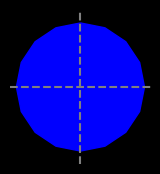

Relationship: Disjoint
|001|
|001|
|001|


In [33]:
a = region_table.at[-0.3, (1, 'b')].polygon
b = np.NaN
plot_ab(a, shapely.Polygon())
print(DE27IM(a, b).identify_relation())
print(DE9IM(a, shapely.Polygon()))


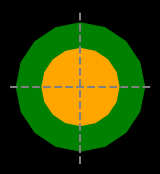

Relationship: Overlaps
|100|
|100|
|111|


In [36]:
a = region_table.at[-0.2, (2, 'c')].polygon
b = region_table.at[-0.2, (1, 'b')].polygon
plot_ab(a, b)
print(DE27IM(a, b).identify_relation())
print(DE9IM(a, b))


((2, 'c'), (1, 'b'), (-0.2, -0.3))
Relationship: Borders
|000|	|000|	|000|
|011|	|000|	|000|
|001|	|000|	|000|

# Logic Error: interpolated slice `(-0.2, -0.3)` is considered a boundary for both structures.  It should be a boundary for `(2, 'c')` only.
- build the interpolated region as the region_table is being constructed.
- This will also be useful for calculating volumes.
- `mid_relations` will need to drop the interpolated slices.
- `identify_neighbour_slices` will not be required.

In [37]:
set_adjustments(region_table, region_boundaries, selected_roi,
                (2, 'c'), (1, 'b'), [-0.2, -0.3])

['boundary_a', 'transpose', 'boundary_b']

In [ ]:
~region_table[[(1, 'b'), (2, 'c')]].isna()

ROI,1,2
Label,b,c
Slice,,
-0.5,False,False
-0.4,False,False
-0.3,True,False
-0.2,True,True
-0.1,True,True
0.0,True,True
0.1,True,True
0.2,True,True


In [24]:
slice_table = cylinders()
selected_roi = [1, 2]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Partition


In [25]:
slice_table = cylinders()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Partition


In [26]:
slice_table = cylinders()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Partition


In [ ]:
slice_table = cylinders()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Partition


In [27]:
slice_table = cylinders()
region_table = make_region_table(slice_table)


In [28]:
selected_roi = [1, 5]


In [29]:
holes = region_table.map(is_hole).apply(any)
structure_regions = region_table.loc[:,~holes][selected_roi]
structure_boundaries = find_boundary_slices(structure_regions)


In [30]:
poly_a, poly_b = selected_roi


- For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.


In [31]:
# Slices that have both primary and secondary structures.
s_p = slice_table.map(empty_structure, invert=True)[selected_roi]
s_p = s_p.apply(all, axis='columns')

# slices that have the secondary structure but not the primary structure.
s_not_p = slice_table.map(empty_structure)[selected_roi].copy()
s_not_p[poly_b] = ~s_not_p[poly_b]
s_not_p = s_not_p.apply(all, axis='columns')

# slices that are boundaries of the primary structure.
primary_b = structure_boundaries[poly_a].copy()


In [32]:
def match_slice(primary_b: pd.Series, sp: pd.Series, selected_roi, shift_dir: int):
    poly_a, poly_b = selected_roi
    n1 = sp & primary_b.shift(shift_dir)
    b1 = n1.index.to_series().shift(shift_dir)[n1]
    b1.name=poly_a
    b1 = b1.reset_index()
    b1.columns = [poly_b, poly_a]
    return b1


- If the neighbouring slice has a Secondary contour, select that Secondary slice.
	

In [33]:

bp = match_slice(primary_b, s_not_p, selected_roi, 1)
bn = match_slice(primary_b, s_not_p, selected_roi, -1)


TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column

- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

In [22]:
b0 = match_slice(primary_b, s_p, selected_roi, 0)


In [ ]:
bn

In [ ]:
selected_roi = [1, 5]
a = slice_table.map(empty_structure, invert=True)[selected_roi]
a.columns = [f'HasContour({roi})' for roi in selected_roi]
b = structure_boundaries[selected_roi]
b.columns = [f'IsBoundary({roi})' for roi in selected_roi]
pd.concat([a, b], axis='columns')

In [ ]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
print(mid_relations[0.4])

In [96]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
#mid_relations

#### Confines Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

  
![Confines cylinder](FreeCAD_Scripts/confines_cylinder.png)



5. Match hole boundary slices for boundary tests:
   - For each hole boundary slice of the Primary ROI, if the slice has a Secondary contour, select that contour for comparison.
   - If the slice does not have a Secondary contour, identify the neighbouring slice that also has a hole.
   - If the neighbouring slice has a Secondary contour, select that contour.
   - If the neighbouring slice does not have a Secondary contour, boundary testing is not required.


  

In [1]:
def confines_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Concentric cylinders ending on the same slice.

<img src="Images\Boundaries\PartitionInf3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\PartitionInf2D.png" alt="PartitionInf2D" style="height:30px;">

In [26]:
def concentric_cylinders_same_end():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    inf_partition = make_vertical_cylinder(roi_num=3, radius=1, length=0.4,
                                           offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, inf_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_end(), [1, 3]))


- Concentric cylinders starting and ending on the same slice.

<img src="Images\Boundaries\Partition3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\Partition2D.png" alt="PartitionInf2D" style="height:30px;">

In [27]:
def concentric_cylinders_same_height():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting and ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    mid_partition = make_vertical_cylinder(roi_num=4, radius=1, length=0.7,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, mid_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_height(), [1, 4]))


### Exterior Borders
  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.

      
![Exterior Border SUP](Images/Boundaries/ExteriorBorders2D_SUP.png)
![Exterior Border INF](Images/Boundaries/ExteriorBorders2D_INF.png)

In [28]:
def stacked_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    outside_cylinder = make_vertical_cylinder(roi_num=5, radius=2, length=0.4,
                                              offset_z=-0.4,
                                              spacing=slice_spacing)
    inside_cylinder = make_vertical_cylinder(roi_num=6, radius=1, length=0.4,
                                             offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, outside_cylinder, inside_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(stacked_cylinders(), [5, 6]))


### Interior Borders
  - Primary: Central Cylinder
  - Concentric shorter hole in the center of the primary cylinder
  - Secondary same height as hole but narrower
  - Interior borders at the and bottom of hole.
  
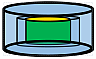
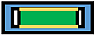

In [29]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=4, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=10, radius=1, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    reference = make_vertical_cylinder(roi_num=11, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole, middle_cylinder, reference])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.

In [30]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(dual_embedded_cylinder(), [1, 2]))


In [ ]:
def overlapping_cylinders():
    slice_spacing = 0.5
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two overlapping cylinders
    top_cylinder = make_vertical_cylinder(roi_num=7, radius=2, length=0.4, offset_z=-0.3, spacing=slice_spacing)
    bottom_cylinder = make_vertical_cylinder(roi_num=8, radius=2, length=0.4, offset_z=0, spacing=slice_spacing)
   # combine the contours
    slice_data = pd.concat([top_cylinder, bottom_cylinder, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(overlapping_cylinders(), [7, 8]))


# More Tests Needed

  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
- **Partition**
  - Concentric cylinders ending on the same slice.
  - Concentric cylinders starting on the same slice
  - Primary: Central Cylinder
    - Single Secondary slice with circular contour on the SUP/INF slice of the Primary cylinder.
  - Single Primary slice with circular contour
    - Secondary: one of:
      - SUP Cylinder ending on the same slice.
      - INF Cylinder ending on the same slice.
- **CONTAINS**
  - Concentric cylinders with interior cylinder ending inside the exterior cylinder by one slice
**OVERLAPS**
  - Concentric cylinders with interior cylinder ending outside the exterior cylinder by one slice
  - Concentric cylinders with interior cylinder consisting of single slice ending inside the exterior cylinder by one slice


  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.
  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
